# Fast Fiction
## D&D Character Generator using an Auto-Encoder
**Advait Ukidve - MSc. Creative Computing at UAL CCI - June 2023**

**Link to GitHub (contains project documentation):** https://github.com/AdvaitU/fast-fiction-ae-dnd-npc-generator    
**Video Demonstration:**

**Project Description:** This notebook uses a CSV Dataset containing 31 unique traits (columns) for 10,894 human created D&D characters (rows) and trains an Auto-encoder model to create a three dimensional representation of all the characters that can then be used to move through to create unique well fleshed-out NPCs for D&D campaigns quickly that fit within a DM-indicated general mould/context. The notebook generates a character description for DMs, a stat sheet, and a prompt using its decoder for a character portrait using Midjourney as the output. (For more, refer to the GitHub).

**Note:** Section descriptions and information can be found in the Markdown cells and code specific details and commentary can be found as comments in the Python cells.
   

### 0.0 Imports

In [1]:
# Data Handling Imports
import pandas as pd  # For reading the CSV File and saving as a dataframe object
import numpy as np # For storing the dataset as Numpy arrays
import matplotlib # For plotting data as line graphs and scatter plots
import matplotlib.pyplot as plt

#Tensorflow Imports
import tensorflow as tf 
from keras.models import Model, Sequential # Default Model (Sequential unused in final version)

from keras.layers import Dense, Activation, Lambda, Input
from keras.layers import Reshape, Flatten, BatchNormalization, Activation

from tensorflow.keras.optimizers.legacy import SGD # Optimisers - Adam used in final model
from keras.losses import mse, binary_crossentropy # Loss functions - MSE used in final model
from keras.utils.vis_utils import plot_model
from keras import backend as K


# Sklearn for clustering
from sklearn.metrics.pairwise import cosine_similarity as cosine
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.decomposition import TruncatedSVD
from sklearn.model_selection import train_test_split # For Splitting pandas dataframe into training and testing sets
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

# Other
import argparse
import os

### 1.0 Importing the Dataset as CSV
Importing and examining the CSV file as a Pandas Dataframe object

In [2]:
df = pd.read_csv("data/dnd_dataset.csv") # CSV placed in directory called 'data' placed in the directory of this notebook
df #Show the first and last few examples of the whole dataset - 10,894 rows x 31 columns

,race,class,background1,background2,hp,ac,castStat,alignment1,alignment2,religion,...,weapon2,armour1,armour2,insignia,connection1,connection2,mannerisms,bonds,appearance,flaw_secret
0,0.0000,1.0000,0.9091,0.5455,0.0,0.1304,0.4,0.5,1.0,0.8174,...,0.1765,0.6667,0.25,0.50,0.0,0.50,1.0000,0.5556,0.5263,0.9091
1,0.0000,0.4545,0.7273,0.3636,0.0,0.1304,0.2,0.5,0.0,0.6264,...,0.6471,0.3333,0.25,0.00,0.0,0.50,0.7368,0.4444,0.4211,0.5455
2,0.1429,0.8182,0.5455,0.7273,0.0,0.1304,0.0,0.5,0.0,0.2686,...,0.2941,1.0000,0.00,0.00,1.0,0.00,0.8947,0.2222,0.3684,0.5455
3,0.3571,0.2727,1.0000,0.0909,0.0,0.1304,0.0,0.5,0.5,0.6887,...,0.1176,1.0000,0.50,1.00,1.0,0.50,0.2632,0.3333,0.5789,0.4545
4,0.3571,1.0000,0.0000,0.2727,0.0,0.1304,0.4,1.0,0.0,0.2183,...,0.7059,0.0000,0.25,0.00,0.0,0.25,0.7368,0.8889,0.7368,0.0909
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10889,0.0000,-0.0909,0.2727,1.0000,1.0,0.3478,0.4,1.0,0.5,0.0324,...,0.1176,0.6667,0.75,0.00,1.0,0.75,0.5789,0.0000,1.0000,0.1818
10890,0.2857,0.5455,0.0000,0.1818,1.0,0.5217,0.4,1.0,1.0,0.5766,...,0.1176,1.0000,0.50,0.25,1.0,0.50,0.7895,0.2222,0.3684,0.5455
10891,1.0000,0.2727,0.0909,0.5455,1.0,0.5652,0.0,0.5,0.0,0.4344,...,0.1176,0.0000,0.00,0.00,0.0,0.25,0.1579,1.0000,0.6316,0.0000
10892,0.2857,0.5455,0.9091,0.2727,1.0,0.5652,0.0,1.0,1.0,0.8528,...,0.0000,1.0000,0.50,1.00,1.0,0.50,0.6842,0.8889,0.5789,1.0000


In [3]:
# Some lines to examine the data - Only the last processed line will be displayed. Comment lines out accordingly.

df["background1"] # Shows only the background1 column, length and type od elements (float64)
#df.head() # Shows the first 5 rows and all columns
#df.plot() # This plots all the columns. The result shows all the data is normalised between 0.0 and 0.1 except height and weight which need otherwise
#df["height"].plot(kind = 'bar',figsize=(15,7)) # Plots only the height column as a bar graph

0        0.9091
1        0.7273
2        0.5455
3        1.0000
4        0.0000
          ...  
10889    0.2727
10890    0.0000
10891    0.0909
10892    0.9091
10893    0.6364
Name: background1, Length: 10894, dtype: float64

### 1.1 Splitting the Dataset

Into x_train and x_test. Since we're using an autoencoder, desired output is the same as input.

In [4]:
# Splitting the Pandas Dataset into Training and Testing Data
# I learned this neat trick from: https://stackoverflow.com/questions/24147278/how-do-i-create-test-and-train-samples-from-one-dataframe-with-pandas

x_train, x_test = train_test_split(df, test_size=0.2) # Split it with testing data size being 20% of the dataset
x_train = x_train.astype('float32') # Save both as float32 types since we don't need 64 bits for these values.
x_test = x_test.astype('float32') # This will make processing them faster
#x_test # Show testing set
x_train # Show training set - 80% of the original dataset (df) - ~8700 rows x 31 columns
# x_train.info() # To see shape of the input and confirm it exists as float32

,race,class,background1,background2,hp,ac,castStat,alignment1,alignment2,religion,...,weapon2,armour1,armour2,insignia,connection1,connection2,mannerisms,bonds,appearance,flaw_secret
5459,0.2857,0.9091,0.6364,0.7273,0.0881,0.3043,0.4,0.0,0.0,0.8322,...,0.0000,1.0000,0.25,0.00,0.0,0.00,1.0000,0.3333,0.3684,0.6364
9932,0.5714,0.5455,0.4545,0.1818,0.3085,0.4783,0.4,0.0,0.0,0.0157,...,0.0588,0.6667,0.50,1.00,1.0,1.00,0.8947,0.3333,0.9474,0.8182
6334,0.4286,0.5455,0.4545,0.3636,0.1051,0.4783,0.4,0.0,0.5,0.6282,...,0.1765,1.0000,0.25,0.50,0.0,0.00,0.5789,0.0000,0.5263,0.3636
9500,0.3571,0.7273,0.3636,1.0000,0.2475,0.5652,0.2,1.0,0.0,0.5691,...,0.8824,0.0000,0.25,1.00,1.0,0.50,0.5263,0.4444,0.8947,0.4545
4858,0.6429,0.7273,0.4545,0.3636,0.0746,0.3913,0.2,1.0,1.0,0.1205,...,0.5294,0.3333,0.00,1.00,1.0,0.25,0.5789,0.8889,0.7368,0.0909
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4584,0.2857,0.8182,0.2727,0.3636,0.0712,0.2174,0.0,0.5,0.5,0.5763,...,0.2941,0.3333,0.75,0.00,0.0,0.50,0.1579,0.2222,0.9474,0.0909
5960,0.7143,0.5455,1.0000,0.5455,0.0983,0.1304,0.4,0.0,0.0,0.0599,...,0.0588,1.0000,0.50,0.75,1.0,0.50,0.8947,0.3333,0.8947,1.0000
7002,0.2857,1.0000,0.6364,1.0000,0.1254,0.3043,0.4,1.0,0.0,0.3710,...,0.1176,1.0000,0.25,0.75,1.0,0.25,0.5263,0.5556,0.6842,0.8182
5132,0.2143,0.1818,0.6364,0.1818,0.0780,0.5217,0.0,1.0,0.0,0.7927,...,1.0000,0.6667,0.25,0.25,0.0,0.50,0.8421,0.5556,0.5263,0.5455


## 2.1 Creating the Autoencoder Model

In [94]:
# Network Parameters
input_shape = 31 # The input_vector is (1,31)
latent_dim = 3 # The target latent vector is (1,3) - hence dimensionality = 3

# Autoencoder = Encoder + Decoder (trained together) = Decoder(Encoder(Inputs))

# Building Encoder Model -------------------------------------------------------------------------------------------- #

inputs = Input(shape=input_shape, name='encoder_input') # Input Layer (shape = (1,31))

x = Dense(input_shape, activation='relu')(inputs)  #(31)
x = Dense(input_shape, activation='relu')(x)       #(31)
x = Dense(input_shape/2, activation='relu')(x)     #(15)
x = Dense(input_shape/2, activation='relu')(x)     #(15)
x = Dense(input_shape/4, activation='relu')(x)     #(7)
x = Dense(input_shape/4, activation='relu')(x)     #(7)
x = Dense(latent_dim, activation='relu')(x)        #(3)

x = BatchNormalization()(x)   #(3)
x = Activation("relu")(x)     #(3)

x = Dense(latent_dim, activation='relu')(x)        #(3)
latent_vector = x  # Save shape to output later

# Instantiating Encoder Model
encoder = Model(inputs, [x] , name='encoder') # Input = inputs; Output = x; Non-Variational

# Building Decoder Model -------------------------------------------------------------------------------------------- #

latent_inputs = Input(shape=(latent_dim,), name='z_sampling') # Input Layer (shape = (1,3))
x = Dense(latent_dim, activation='relu')(latent_inputs)   #(3)
x = Dense(latent_dim, activation='relu')(x)   #(3)

x = BatchNormalization()(x) #(3)
x = Activation("relu")(x) #(3)

x = Dense(input_shape/4, activation='relu')(x)       #(7)
x = Dense(input_shape/4, activation='relu')(x)       #(7)
x = Dense(input_shape/2, activation='relu')(x)       #(15)
x = Dense(input_shape/2, activation='relu')(x)       #(15)
x = Dense(input_shape, activation='relu')(x)         #(31)
x = Dense(input_shape, activation='relu')(x)         #(31)
outputs = Dense(input_shape, activation='relu')(x)   #(31)


# Instantiating Decoder Model
decoder = Model(latent_inputs, outputs, name='decoder') # Input = latent_inputs(x); Output = outputs;

# ------------------------------------------------------------------------------------------------------------- #

# Instantiating VAE Model
outputs = decoder(encoder(inputs))  # Outputs are the inputs run through the encoder run through the decoder
ae = Model(inputs, outputs, name='ae_dnd') # ae = Autoencoder


### 2.1.1 Summarising VAE Model

For quick reference:

In [95]:
# ENCODER
print("Input Shape: ", end="") # end = "" --> To print the next statement in the same line
print(inputs.get_shape())
print("Encoder Summary: ")
encoder.summary() # Print Encoder Summary

# LATENT VECTOR
print("Latent Vector Shape: ", end="")
print(latent_vector.get_shape())

# DECODER
print("Output Shape:", end="")
print(outputs.get_shape())
print("Decoder Summary: ")
decoder.summary() # Print Decoder Summary

# VAE MODEL
print("VAE Model Summary: ")
ae.summary() # Print VAE Model Summary

Input Shape: (None, 31)
Encoder Summary: 
Model: "encoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 encoder_input (InputLayer)  [(None, 31)]              0         
                                                                 
 dense_48 (Dense)            (None, 31)                992       
                                                                 
 dense_49 (Dense)            (None, 31)                992       
                                                                 
 dense_50 (Dense)            (None, 15)                480       
                                                                 
 dense_51 (Dense)            (None, 15)                240       
                                                                 
 dense_52 (Dense)            (None, 7)                 112       
                                                                 
 dense_53 (Dense)

## 2.2 Compile and Train Model

In [96]:
# Compile the model using adam optimiser and mse loss function

models = (encoder, decoder)
y_test = x_test # Set target for testing data to be same as testing data - Different names to avoid any confusion in the future
data = (x_test, y_test)
y_train = x_train # Set target for training data to be same as training data

ae.compile(optimizer='adam', loss='mse') # MSE used with ref to: https://towardsdatascience.com/loss-functions-and-their-use-in-neural-networks-a470e703f1e9 since the data wasn't purely categorical or binary in nature

# Tried various optimisers - Won't pretend I have a great understanding of each - used the 'try all and see' method and adam gave the most accurate results closely followed bg sgd
# Understood a little bit about optimizers before using them here: https://www.analyticsvidhya.com/blog/2021/10/a-comprehensive-guide-on-deep-learning-optimizers/

In [97]:
batch_size = 32 # Change the values once every 32 samples
epochs = 100 # Run through all the data 100 times in total

history = ae.fit(x_train, y_train, epochs=epochs, shuffle=True, batch_size=batch_size, validation_data=(x_test, y_test))
# variable_for_plotting = model.fit(train_set, train_target, epochs, shuffle, batch_size, validation_data = (test_set, test_target))

Epoch 1/100
273/273 [==============================] - 3s 4ms/step - loss: 0.1529 - val_loss: 0.1263
Epoch 2/100
273/273 [==============================] - 1s 2ms/step - loss: 0.1190 - val_loss: 0.1183
Epoch 3/100
273/273 [==============================] - 1s 3ms/step - loss: 0.1173 - val_loss: 0.1163
Epoch 4/100
273/273 [==============================] - 1s 3ms/step - loss: 0.1170 - val_loss: 0.1174
Epoch 5/100
273/273 [==============================] - 1s 3ms/step - loss: 0.1167 - val_loss: 0.1159
Epoch 6/100
273/273 [==============================] - 1s 2ms/step - loss: 0.1165 - val_loss: 0.1156
Epoch 7/100
273/273 [==============================] - 1s 3ms/step - loss: 0.1164 - val_loss: 0.1156
Epoch 8/100
273/273 [==============================] - 1s 3ms/step - loss: 0.1159 - val_loss: 0.1146
Epoch 9/100
273/273 [==============================] - 1s 3ms/step - loss: 0.1152 - val_loss: 0.1149
Epoch 10/100
273/273 [==============================] - 1s 3ms/step - loss: 0.1150 - val_lo

## 2.3 Examining and Saving the Model

First, we will examine the model and plot the loss over epochs.

Loss and Val_Loss over Epochs:


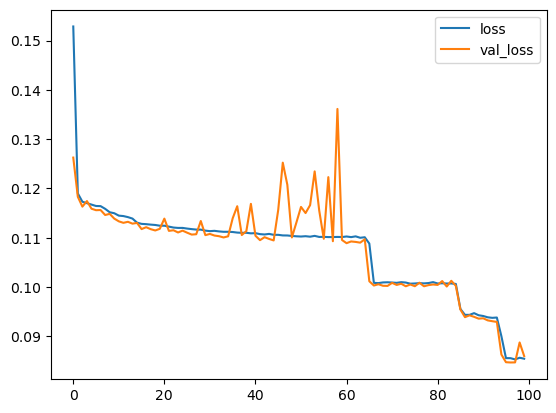

In [98]:
# How did we do?
loss = history.history["loss"]
val_loss = history.history["val_loss"]

epochs_array = list(range(epochs)) # 1 to 100
plt.plot(epochs_array, loss, label="loss") # Plot loss on the y-axis against epochs_array in the x-axis
plt.plot(epochs_array, val_loss, label="val_loss") # Same for val_loss
plt.legend()

print("Loss and Val_Loss over Epochs:")

The graph shows the loss decreases over epochs to settle at a negligible value.

#### Saving Models as JSON and H5

In [99]:
# Saves the models as JSON and weights as H5 files in the same directory as the notebook
import json

# SAVE FUNCTION DEFINITION
def save_model(model, name):  # Technique thanks to Week 4 VAE Code: 
    model_json = model.to_json()
    with open(name+".json", "w") as json_file:
        json.dump(model_json, json_file)

    model.save_weights(name+".h5")

# SAVE MODELS
save_model(encoder,'dnd_encoder')
save_model(decoder,'dnd_decoder')

#### Loading the Models

In [100]:
# Loading it back (in the same notebook)

# IMPORTS
from keras.models import load_model
from keras.models import model_from_json
import json

# LOAD FUNCTION DEFINITION
def my_load_model(name): # Technique thanks to Week 4 VAE Code: 
    with open(name+'.json','r') as f:
        model_json = json.load(f)

    model = model_from_json(model_json)
    model.load_weights(name+'.h5')
    return model

# LOAD MODELS
decoder = my_load_model('dnd_decoder')
encoder = my_load_model('dnd_encoder')

# 3. Examining the Model's Performance

In this section, we examine the train model in various ways to look at its accuracy in deconstructing and reconstructing vectors.   
(a) We examine original vectors from the training set (x_train) and their latent vectors and reconstructions and plot the accuracy.   
(b) We repeat the same for, more importantly, the training set (x_test)   
(c) We plot all the latent vectors from the testing data in a 3 dimensional embedded space to sexamine their distribution and see if any patterns emerge.    

**Note for (c):** Since it was difficult to perform observations and mark distinct patterns given the scale of the data and the timeframe, I examined the data in a few specific instances. These can be viewed as reflections of larger patterns and, hence, the indicative yet partial truth with more verification required. The results can be seen in 5.4

## 3.1 Examining vectors from Training Data

First we choose a random vector from the training set. We then run the whole training set through the encoder and print both the original vector and the 3-d latent vector.

In [101]:
#Testing for a specific row in x_train

index = 981 # Random number of one's choosing
x1 = x_train.iloc[index] # Save row at index in x_train as x1
print(x1) # Print x1 to screen

z = encoder.predict(x_train) # Run all of x_train through encoder
z[index] # Print that index from the encoded set

race              0.2857
class             1.0000
background1       0.5455
background2       0.5455
hp                0.3017
ac                0.2174
castStat          0.4000
alignment1        1.0000
alignment2        0.5000
religion          0.0355
gender            0.3827
wealth            0.4683
a_strength        0.5667
a_dexterity       0.6000
a_constitution    0.5333
a_intelligence    0.4333
a_wisdom          0.5000
a_charisma        0.5000
height            1.4987
weight            1.3728
weapon1           0.2941
weapon2           0.2941
armour1           0.3333
armour2           0.2500
insignia          0.0000
connection1       0.0000
connection2       0.5000
mannerisms        0.2105
bonds             0.0000
appearance        0.7895
flaw_secret       0.5455
Name: 9871, dtype: float32
273/273 [==============================] - 0s 968us/step


array([0.4879158 , 0.        , 0.39637154], dtype=float32)

Next, we run the encoded vector through the decoder and print it out

In [102]:
# Predicting

y1 = decoder.predict(z) # Run all of z through the decoder
y1[index] # Print that index row's decoded version

273/273 [==============================] - 0s 965us/step


array([0.34265485, 0.45304084, 0.47232577, 0.        , 0.12506042,
       0.36009613, 0.16409133, 0.69138515, 0.        , 0.4852755 ,
       0.50583893, 0.49792248, 0.43211693, 0.4728065 , 0.4788714 ,
       0.39291418, 0.43536782, 0.43253303, 0.98531663, 1.002383  ,
       0.24864471, 0.2545301 , 0.18352622, 0.39500093, 0.49847835,
       0.        , 0.24171278, 0.4813649 , 0.        , 0.48012775,
       0.48882705], dtype=float32)

### Comparing the Original Vector and the Reconstructed vector

Plot:


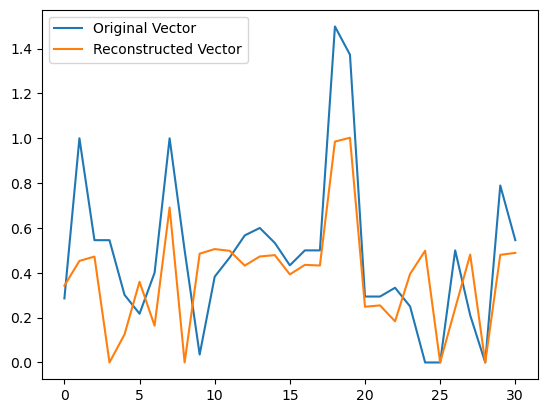

In [103]:
x_axis_spread = list(range(31)) # 1 to 31 for all 31 dimensions
plt.plot(x_axis_spread, x1, label="Original Vector") # Plot original vector
plt.plot(x_axis_spread, y1[index], label="Reconstructed Vector") # Plot reconstructed vector
plt.legend()

print("Plot:")

## 3.2 Examining vectors from Testing Data

Then we choose a random vector from the testing set. We then run the whole testing set through the encoder and print both the original vector and the 3D latent vector.

In [104]:
#Testing for a specific row in x_test

x2 = x_test.iloc[index] # Save row at index in x_test as x2
print(x2) # Print x2 to screen

z2 = encoder.predict(x_test) # Run all of x_test through encoder
z2[index] # Print that index from the encoded set

race              0.5714
class             0.7273
background1       0.4545
background2       0.2727
hp                0.0542
ac                0.3913
castStat          0.2000
alignment1        0.5000
alignment2        1.0000
religion          0.7934
gender            0.4596
wealth            0.6198
a_strength        0.3333
a_dexterity       0.5333
a_constitution    0.4667
a_intelligence    0.4667
a_wisdom          0.3667
a_charisma        0.4667
height            0.8677
weight            1.3787
weapon1           0.1176
weapon2           0.1176
armour1           0.6667
armour2           0.2500
insignia          0.7500
connection1       1.0000
connection2       1.0000
mannerisms        0.3684
bonds             0.8889
appearance        1.0000
flaw_secret       0.9091
Name: 3808, dtype: float32
69/69 [==============================] - 0s 889us/step


array([0.69617784, 0.        , 0.80764854], dtype=float32)

In [105]:
# Predicting

y2 = decoder.predict(z2) # Run all of z through the decoder
y2[index] # Print that index row's decoded version

69/69 [==============================] - 0s 875us/step


array([0.33757657, 0.450557  , 0.48456323, 0.        , 0.11473624,
       0.36545593, 0.15598491, 0.2709011 , 0.        , 0.501104  ,
       0.5285487 , 0.47192234, 0.4327965 , 0.47588074, 0.48216748,
       0.39272022, 0.4403425 , 0.43779698, 1.0065366 , 1.006411  ,
       0.25109375, 0.25291002, 0.8755368 , 0.29060328, 0.48229885,
       0.9954143 , 0.5357509 , 0.5077197 , 0.        , 0.49028978,
       0.5182171 ], dtype=float32)

### Comparing the Original Vector and the Reconstructed vector

Plot:


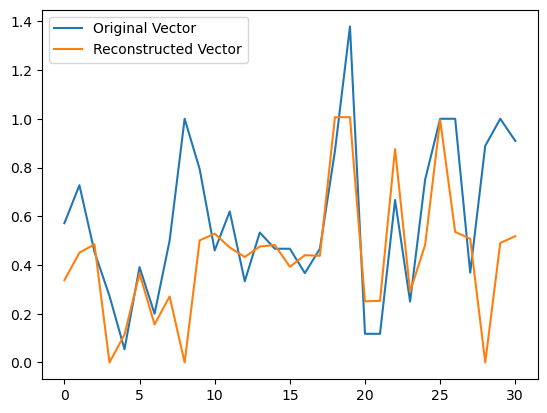

In [106]:
plt.plot(x_axis_spread, x2, label="Original Vector") # Plot original vector
plt.plot(x_axis_spread, y2[index], label="Reconstructed Vector") # Plot reconstructed vector
plt.legend()

print("Plot:")

## 3.3 Plotting the Latent Vectors in 3D space

Next, we use matplotlib's 3D scatter plot to map the 3-Dimensional latent vectors in 3D space with their respective elements taken as x-axis, y-axis, and z-axis co-ordinates respectively. Hence, a latent vector of the form array(\[0.16366398, 0.        , 0.18506195\], dtype=float32) above would be represented as point n(0.16, 0.00, 0.18)

### Converting z2 (latent vectors of the testing set above) to (x, y ,z) format for matplotlib

Matplotlib requires 3 lists containing equal number of elements. The corresponding elements of these 3 lists are used to stitch together the co-ordinate of the point described at that index.

In [107]:
# Thanks to https://www.geeksforgeeks.org/3d-scatter-plotting-in-python-using-matplotlib/ for teaching me how to do 3D scatter Plots with Matplotlib

xVal, yVal, zVal = [],[],[] # Initiating 3 empty lists to contain the co-ordinates in the necessary format

for i in range(z2.shape[0]):  # z2's shape is (2179, 3)
    xVal.append(z2[i][0])     # First column of each row saved in xVal list
    yVal.append(z2[i][1])     # Same for yVal and zVal
    zVal.append(z2[i][2])

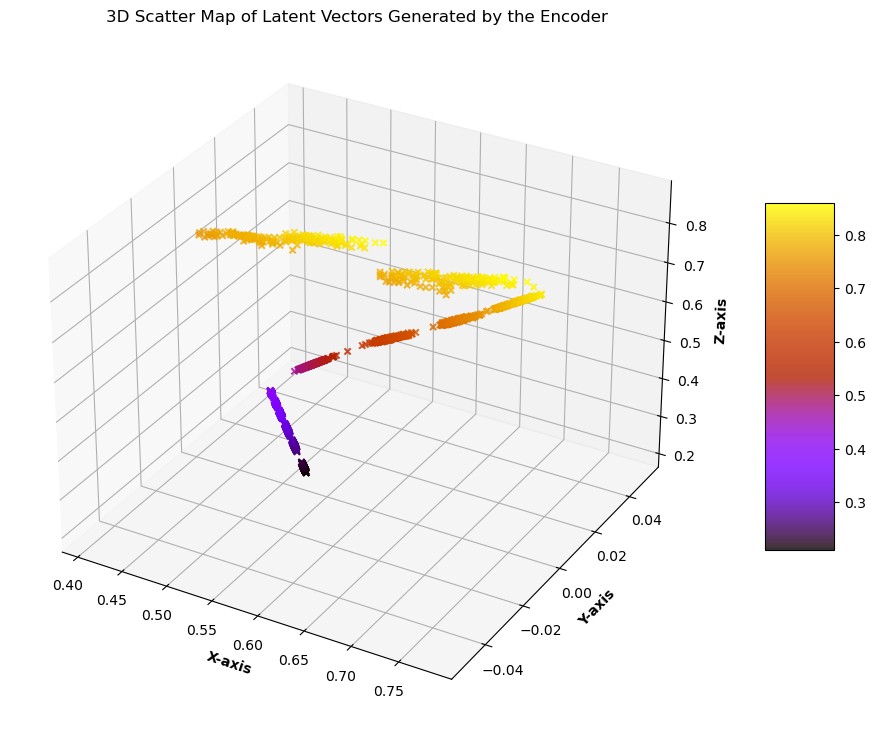

In [108]:
# 3D Scatter Plot using matplotlib
# https://matplotlib.org/stable/api/markers_api.html for style reference

# Import libraries
from mpl_toolkits import mplot3d

# Creating figure
fig = plt.figure(figsize = (16, 9))
ax = plt.axes(projection ="3d")

# Add x, y gridlines
ax.grid(b = True, color ='grey',linestyle ='-.', linewidth = 0.3, alpha = 0.2)

# Creating color map
my_cmap = plt.get_cmap('gnuplot') # Style Reference: https://www.w3schools.com/python/matplotlib_scatter.asp

# Creating plot
sctt = ax.scatter3D(xVal, yVal, zVal, alpha = 0.8, c = (zVal), cmap = my_cmap, marker ='x') # Style Reference: https://matplotlib.org/stable/api/markers_api.html
# Create scatter map. Colour individual points by z-axis value only.

plt.title("3D Scatter Map of Latent Vectors Generated by the Encoder")
ax.set_xlabel('X-axis', fontweight ='bold')
ax.set_ylabel('Y-axis', fontweight ='bold')
ax.set_zlabel('Z-axis', fontweight ='bold')
fig.colorbar(sctt, ax = ax, shrink = 0.5, aspect = 5) # Add colour bar to indicate relevance of colour

# show plot
plt.show()


# 4. Generating New Characters 

This section creates latent vectors at random points within the bounds of the embedded space to create new D&D characters that are similar to but not the same as characters in the original dataset.

### 4.1 Creating a random vector at a point in the space

In [109]:
# First we create a random 3D vector in the latent space
# For this, we need to know the bounds of the latent space where all the co-ordinates are in the lists xVal, yVal, and zVal created above.
from random import random # Import Python Random module

# After a lot of searching, I got this from https://stackoverflow.com/questions/22071987/generate-random-array-of-floats-between-a-range

rand_vec = np.random.uniform(low = min(xVal + yVal + zVal), high = max(xVal + yVal + zVal), size = (1,3))
print("Random Vector: " + str(rand_vec)) # Print the randomly generated 3D vector

gen = decoder.predict(rand_vec)
print("Reconstructed Vector: " + str(gen))

Random Vector: [[0.22644067 0.30062204 0.24719229]]
1/1 [==============================] - 0s 19ms/step
Reconstructed Vector: [[0.34199393 0.43042928 0.47114494 0.         0.10950626 0.3605095
  0.15161765 0.77026975 0.         0.49769408 0.5164026  0.48055398
  0.43978733 0.4779004  0.48192012 0.39662084 0.43584192 0.43546173
  1.012274   1.0174202  0.25258458 0.25153664 0.853505   0.3059404
  0.4918499  0.9931186  0.5395398  0.49333078 0.         0.4931433
  0.50777483]]


In [110]:
# Creating a 1D List copy of gen called 'feat' to use in the following text extraction sequence.

feat = [] # Create a copy of gen as a simple list to hold all the values.

for k in range(gen.shape[1]): # Fill all values from gen(1,31) in feat(31) one by one
    feat.append(gen[0][k]) 
    
#feat[0] # Output the first value to confirm feat is the same as gen

## 4.2 - Text Extracting Functions
**Note: This is a long section that you can ignore. Use the following to [jump to Section 4.3](#the_destination)**    

Functions to extract meaning from the reconstructed vector using the rules listed in GroundTruth.xlxs.

In [111]:
# Defining a function that checks whether a given float is within a range
# Thanks to: https://stackoverflow.com/questions/25466104/how-to-check-if-a-float-value-is-within-a-certain-range-and-has-a-given-number-o

def check(value, minm, maxm):
    if minm <= value < maxm:
        return True
    return False

In [112]:
output_string = "" # Initialising the output string

# ADD RACE FUNCTION -----------------------------------------------------
# Sets the template for all functions - take feat[n] i.e. float32 as input along with string and append something to the string and then return it.

def addRace(to_check):
    
    if check(to_check, 0.0, 0.07):
        out_str = "gnome"
    elif check(to_check, 0.07, 0.14):
        out_str = "dwarf"
    elif check(to_check, 0.14, 0.21):
        out_str = "halfling"
    elif check(to_check, 0.21, 0.28):
        out_str = "human"
    elif check(to_check, 0.28, 0.35):
        out_str = "half-elf"
    elif check(to_check, 0.35, 0.42):
        out_str = "elf"
    elif check(to_check, 0.42, 0.49):
        out_str = "half-orc"
    elif check(to_check, 0.49, 0.56):
        out_str = "tiefling"
    elif check(to_check, 0.56, 0.63):
        out_str = "dragonborn"
    elif check(to_check, 0.63, 0.7):
        out_str = "goblin"
    elif check(feat[0], 0.7, 0.77):
        out_str = "genasi"
    elif check(to_check, 0.77, 0.84):
        out_str = "lizardfolk"
    elif check(to_check, 0.84, 0.93):
        out_str = "orc"
    elif check(to_check, 0.93, 0.96):
        out_str = "satyr"
    else:
        out_str = "minotaur"
    
    return out_str

# Class Function --------------------------------------------------------------------------------
def addClass(to_check):
    
    if check(to_check, -1.0, 0.09):
        out_str = "monk"
    elif check(to_check, 0.09, 0.18):
        out_str = "barbarian"
    elif check(to_check, 0.18, 0.27):
        out_str = "fighter"
    elif check(to_check, 0.27, 0.36):
        out_str = "rogue"
    elif check(to_check, 0.36, 0.45):
        out_str = "bard"
    elif check(to_check, 0.45, 0.54):
        out_str = "ranger"
    elif check(to_check, 0.54, 0.63):
        out_str = "paladin"
    elif check(to_check, 0.63, 0.72):
        out_str = "druid"
    elif check(to_check, 0.72, 0.81):
        out_str = "cleric"
    elif check(to_check, 0.81, 0.9):
        out_str = "wizard"
    elif check(to_check, 0.9, 0.99):
        out_str = "warlock"
    else:
        out_str = "sorcerer"
        
    return out_str

# Background Function -----------------------------------------------------------------------------
def addBG(to_check):
    
    if check(to_check, -1.0, 0.09):
        out_str = "merchant"
    elif check(to_check, 0.09, 0.18):
        out_str = "manufacturer of goods"
    elif check(to_check, 0.18, 0.27):
        out_str = "government official"
    elif check(to_check, 0.27, 0.36):
        out_str = "scholar"
    elif check(to_check, 0.36, 0.45):
        out_str = "doctor"
    elif check(to_check, 0.45, 0.54):
        out_str = "mercenary"
    elif check(to_check, 0.54, 0.63):
        out_str = "entertainer"
    elif check(to_check, 0.63, 0.72):
        out_str = "criminal"
    elif check(to_check, 0.72, 0.81):
        out_str = "soldier"
    elif check(to_check, 0.81, 0.9):
        out_str = "artisan"
    elif check(to_check, 0.9, 0.99):
        out_str = "sailor"
    else:
        out_str = "wizard"
        
    return out_str

# Hitpoints --------------------------------------------------------------------------------------
def addHP(to_check):
    hitpts = round(to_check * 300, 0) # Multiply hitpoints by 300 per GroundTruth and round it to nearest full integer
    return str(int(hitpts)) # Return as string version of the int version of the calculated float

# Armour Class -----------------------------------------------------------------------------------
def addAC(to_check):
    ac = round(to_check * 30, 0) # Multiply hitpoints by 300 per GroundTruth and round it to nearest full integer
    return str(int(ac)) # Return as string version of the int version of the calculated float

# Cast Stat --------------------------------------------------------------------------------------
def addCastStat(to_check):
    if check(to_check, -1.0, 0.2):
        out_str = "intelligence"
    elif check(to_check, 0.2, 0.4):
        out_str = "wisdom"
    elif check(to_check, 0.4, 0.6):
        out_str = "charisma"
    elif check(to_check, 0.6, 0.8):
        out_str = "strength"
    elif check(to_check, 0.8, 0.98):
        out_str = "constitution"
    else:
        out_str = "dexterity"
        
    return out_str

# Alignment --------------------------------------------------------------------------------------
def addAlign(to_check1, to_check2):
    if check(to_check1, -1.0, 0.4):
        out_str = "lawful-"
        
        if check(to_check2, -1.0, 0.4):    
            out_str += "good"
        elif check(to_check2, 0.4, 0.75):
            out_str += "neutral"
        else:
            out_str += "evil"
        
    elif check(to_check1, 0.4, 0.75):
        out_str = "neutral-"
        
        if check(to_check2, -1.0, 0.4):
            out_str += "good"
        elif check(to_check2, 0.4, 0.75):
            out_str = "true neutral"
        else:
            out_str += "evil"
    else:
        out_str = "chaotic-"
        
        if check(to_check2, -1.0, 0.4):
            out_str += "good"
        elif check(to_check2, 0.4, 0.75):
            out_str += "neutral"
        else:
            out_str += "evil"
        
    return out_str

# Religion --------------------------------------------------------------------------------------
def addReligion(to_check):
    return str(round(to_check * 10, 2))

# Gender ----------------------------------------------------------------------------------------
def addGender(to_check): 
    return str(round(to_check * 10, 2)) 

# Describe Gender - For Stable Diffusion ---------------------------------------------------------
def describeGender(to_check):
    if check(to_check, -1.0, 0.2):
        out_str = "masculine"
    elif check(to_check, 0.2, 0.4):
        out_str = "somewhat masculine"
    elif check(to_check, 0.4, 0.6):
        out_str = "neither masculine nor feminine"
    elif check(to_check, 0.6, 0.8):
        out_str = "somewhat feminine"
    else:
        out_str = "feminine"
        
    return out_str

# Wealth -----------------------------------------------------------------------------------------
def addWealth(to_check):
    return str(int(round(to_check * 1000, 2))) # String of integer version of the rounded result of the float multiplied by 1000 to two decimals

# Attributes - STR, DEX, CON, INT, WIS, CHA (in that order) --------------------------------------
def addAttribute(to_check):
    return str(int(round(to_check * 30, 2))) # Multiply by 30 and round to nearest integer to get value of attribute

# Height -----------------------------------------------------------------------------------------
def addHeight(to_check, to_check2):
    if check(to_check, 0.0, 0.07):
        inches = 36 * to_check2       # Average height of race given by to_check multiplied by to_check2 which is a factor between 0.5 and 1.5
    elif check(to_check, 0.07, 0.14):
        inches = 48 * to_check2
    elif check(to_check, 0.14, 0.21):
        inches = 36 * to_check2 
    elif check(to_check, 0.21, 0.28):
        inches = 66 * to_check2 
    elif check(to_check, 0.28, 0.35):
        inches = 66 * to_check2 
    elif check(to_check, 0.35, 0.42):
        inches = 72 * to_check2 
    elif check(to_check, 0.42, 0.49):
        inches = 72 * to_check2 
    elif check(to_check, 0.49, 0.56):
        inches = 66 * to_check2 
    elif check(to_check, 0.56, 0.63):
        inches = 72 * to_check2 
    elif check(to_check, 0.63, 0.7):
        inches = 36 * to_check2 
    elif check(feat[0], 0.7, 0.77):
        inches = 66 * to_check2 
    elif check(to_check, 0.77, 0.84):
        inches = 66 * to_check2 
    elif check(to_check, 0.84, 0.93):
        inches = 54 * to_check2 
    elif check(to_check, 0.93, 0.96):
        inches = 42 * to_check2 
    else:
        inches = 96 * to_check2 
    
    feet = round(inches/12, 2) # Divide by 12 and round it down to get feet
    inches = feet % 12         # Modulo by 12 to get remainder inches
    
    return str(int(feet)) + "\'" + str(int(inches))

# Weight ----------------------------------------------------------------------------------------
def addWeight(to_check, to_check2):
    if check(to_check, 0.0, 0.07):
        pounds = 40 * to_check2       # Average weight of race given by to_check multiplied by to_check2 which is a factor between 0.5 and 1.5
    elif check(to_check, 0.07, 0.14):
        pounds = 150 * to_check2
    elif check(to_check, 0.14, 0.21):
        pounds = 40 * to_check2 
    elif check(to_check, 0.21, 0.28):
        pounds = 110 * to_check2 
    elif check(to_check, 0.28, 0.35):
        pounds = 100 * to_check2 
    elif check(to_check, 0.35, 0.42):
        pounds = 100 * to_check2 
    elif check(to_check, 0.42, 0.49):
        pounds = 175 * to_check2 
    elif check(to_check, 0.49, 0.56):
        pounds = 180 * to_check2 
    elif check(to_check, 0.56, 0.63):
        pounds = 250 * to_check2 
    elif check(to_check, 0.63, 0.7):
        pounds = 60 * to_check2 
    elif check(feat[0], 0.7, 0.77):
        pounds = 160 * to_check2 
    elif check(to_check, 0.77, 0.84):
        pounds = 225 * to_check2 
    elif check(to_check, 0.84, 0.93):
        pounds = 255 * to_check2 
    elif check(to_check, 0.93, 0.96):
        pounds = 125 * to_check2 
    else:
        pounds = 300 * to_check2 
    
    return str(int(round(pounds, 2)))

# Weapon ----------------------------------------------------------------------------------------
def addWeapon(to_check, to_check2):
    if check(to_check, 0.0, 0.25):
        if check(to_check2, 0.0, 0.11):
            out_str = "club"
        elif check(to_check2, 0.11, 0.22):
            out_str = "dagger"
        elif check(to_check2, 0.22, 0.33):
            out_str = "greatclub"
        elif check(to_check2, 0.33, 0.44):
            out_str = "handaxe"
        elif check(to_check2, 0.44, 0.55):
            out_str = "javelin"
        elif check(to_check2, 0.55, 0.66):
            out_str = "light hammer"
        elif check(to_check2, 0.66, 0.77):
            out_str = "mace"
        elif check(to_check2, 0.77, 0.88):
            out_str = "quarterstaff"
        elif check(to_check2, 0.88, 0.99):
            out_str = "sickle"
        else:
            out_str = "spear"
    elif check(to_check, 0.25, 0.5):
        if check(to_check2, 0.0, 0.25):
            out_str = "light crossbow"
        elif check(to_check2, 0.25, 0.5):
            out_str = "dart"
        elif check(to_check2, 0.5, 0.75):
            out_str = "shortbow"
        else:
            out_str = "sling"
    elif check(to_check, 0.5, 0.75):
        if check(to_check2, 0.0, 0.11):
            out_str = "battleaxe"
        elif check(to_check2, 0.11, 0.22):
            out_str = "flail"
        elif check(to_check2, 0.22, 0.33):
            out_str = "greataxe"
        elif check(to_check2, 0.33, 0.44):
            out_str = "greatsword"
        elif check(to_check2, 0.44, 0.55):
            out_str = "halberd"
        elif check(to_check2, 0.55, 0.66):
            out_str = "lance"
        elif check(to_check2, 0.66, 0.77):
            out_str = "longsword"
        elif check(to_check2, 0.77, 0.88):
            out_str = "maul"
        elif check(to_check2, 0.88, 0.99):
            out_str = "warhammer"
        else:
            out_str = "rapier"
    else:
        if check(to_check2, 0.0, 0.25):
            out_str = "hand crossbow"
        elif check(to_check2, 0.25, 0.5):
            out_str = "heavy crossbow"
        elif check(to_check2, 0.5, 0.75):
            out_str = "longbow"
        else:
            out_str = "net"
    
    return out_str

# Armour ----------------------------------------------------------------------------------------
def addArmour (to_check, to_check2):
    if check(to_check, 0.0, 0.25):
        if check(to_check2, 0.0, 0.33):
            out_str = "plain leather"
        elif check(to_check2, 0.33, 0.66):
            out_str = "studded leather"
        else:
            out_str = "padded leather"   
        out_str += " light armor"
    elif check(to_check, 0.25, 0.5):
        if check(to_check2, 0.0, 0.2):
            out_str = "hide"
        elif check(to_check2, 0.2, 0.4):
            out_str = "breastplate and"
        elif check(to_check2, 0.2, 0.4):
            out_str = "chain shirt" 
        elif check(to_check2, 0.2, 0.4):
            out_str = "half plate"
        else:
            out_str = "scale mail"
        out_str += " medium armor"
    elif check(to_check, 0.5, 0.75):
        if check(to_check2, 0.0, 0.25):
            out_str = "ring mail"
        elif check(to_check2, 0.25, 0.5):
            out_str = "chain mail"
        elif check(to_check2, 0.5, 0.75):
            out_str = "splint"
        else:
            out_str = "plated"   
        out_str += " heavy armor"
    else:
        if check(to_check2, 0.0, 0.33):
            out_str = "short"
        elif check(to_check2, 0.33, 0.66):
            out_str = "medium-sized"
        else:
            out_str = "tall tower"   
        out_str += " shield"
    
    return out_str
    
# Insignia ---------------------------------------------------------------------------------------
def addInsignia(to_check2):
    if check(to_check2, 0.0, 0.2):
        out_str = "no noticeable"
    elif check(to_check2, 0.2, 0.4):
        out_str = "tiny, easy to miss"
    elif check(to_check2, 0.2, 0.4):
        out_str = "small yet noticeable" 
    elif check(to_check2, 0.2, 0.4):
        out_str = "prominent"
    else:
        out_str = "overwhelmingly large"
    
    return out_str

# Connection -------------------------------------------------------------------------------------
def addConnection(to_check, to_check2):
    if check(to_check, 0.0, 0.5):
        if check(to_check2, 0.0, 0.33):
            out_str = "are not connected to the players at all"
        elif check(to_check2, 0.33, 0.66):
            out_str = "are related to a place the characters have been in"
        else:
            out_str = "are related to people the characters have interacted with"
    else: 
        if check(to_check2, 0.0, 0.25):
            out_str = "have heard first-hand recollections of the character's adventures in the past"
        elif check(to_check2, 0.25, 0.5):
            out_str = "have distant memories of one or more of the characters  in the party"
        elif check(to_check2, 0.5, 0.75):
            out_str = "are an acquiantance of one or more characters in the party"
        else:
            out_str = "are a close friend/relative of one or more characters in the party"
    
    return out_str

# Mannerisms -------------------------------------------------------------------------------------
def addMannerisms(to_check):
    
    if check(to_check, -1.0, 0.05):
        out_str = "are prone to singing, whistling or humming quietly"
    elif check(to_check, 0.05, 0.1):
        out_str = "speak in rhyme or some peculiar way"
    elif check(to_check, 0.1, 0.15):
        out_str = "have a particularyly low or high voice"
    elif check(to_check, 0.15, 0.2):
        out_str = "often slur words, lisp, or stutter"
    elif check(to_check, 0.2, 0.25):
        out_str = "enunciate over-clearly"
    elif check(to_check, 0.25, 0.3):
        out_str = "speak extremely loudly"
    elif check(to_check, 0.3, 0.35):
        out_str = "speak mostly in whispers and grumbles"
    elif check(to_check, 0.35, 0.4):
        out_str = "use flowery speech and/or long words often"
    elif check(to_check, 0.4, 0.45):
        out_str = "frequently use the wrong words"
    elif check(to_check, 0.45, 0.5):
        out_str = "use colourful oaths and exclamations often"
    elif check(to_check, 0.5, 0.55):
        out_str = "make constant jokes and puns"
    elif check(to_check, 0.55, 0.6):
        out_str = "are prone to predictions of doom"
    elif check(to_check, 0.6, 0.65):
        out_str = "fidget a lot"
    elif check(to_check, 0.65, 0.7):
        out_str = "squint their eyes often"
    elif check(to_check, 0.7, 0.75):
        out_str = "have a tendency to stare into the distance"
    elif check(to_check, 0.75, 8):
        out_str = "are always chewing on something"
    elif check(to_check, 0.8, 0.85):
        out_str = "pace constantly"
    elif check(to_check, 0.85, 0.9):
        out_str = "tap their fingers and toes continuously"
    elif check(to_check, 0.9, 0.95):
        out_str = "bite their fingernails"
    else:
        out_str = "twirl their hair frequently."
        
    return out_str

# Bonds ------------------------------------------------------------------------------------------
def addBonds(to_check):
    if check(to_check, -1.0, 0.125):
        out_str = "are dedicated to fulfilling a personal life goal"
    elif check(to_check, 0.125, 0.25):
        out_str = "are protective of close family members"
    elif check(to_check, 0.25, 0.375):
        out_str = "are protective of colleagues or compatriots"
    elif check(to_check, 0.375, 0.5):
        out_str = "are loyal to a benefactor, patron, or employer"
    elif check(to_check, 0.5, 0.625):
        out_str = "are deeply captivated by a romantic interest"
    elif check(to_check, 0.625, 0.75):
        out_str = "are drawn to a special place"
    elif check(to_check, 0.75, 0.875):
        out_str = "are protective of a sentimental keepsake"
    else:
        out_str = "are out for revenge"
    
    return out_str

# Appearance -------------------------------------------------------------------------------------
def addAppearance(to_check):
    
    if check(to_check, -1.0, 0.05):
        out_str = "are wearing distinctive jewellery"
    elif check(to_check, 0.05, 0.1):
        out_str = "have piercings on various kinds"
    elif check(to_check, 0.1, 0.15):
        out_str = "wear flamboyant and outlandish clothes"
    elif check(to_check, 0.15, 0.2):
        out_str = "have on formal clean clothes"
    elif check(to_check, 0.2, 0.25):
        out_str = "have a pronounced scar"
    elif check(to_check, 0.25, 0.3):
        out_str = "have missing teeth"
    elif check(to_check, 0.3, 0.35):
        out_str = "have eyes of different colours"
    elif check(to_check, 0.35, 0.4):
        out_str = "have many tattoos"
    elif check(to_check, 0.4, 0.45):
        out_str = "have a large birthmark"
    elif check(to_check, 0.45, 0.5):
        out_str = "have an unusual skin colour"
    elif check(to_check, 0.5, 0.55):
        out_str = "are balding"
    elif check(to_check, 0.55, 0.6):
        out_str = "have long braids"
    elif check(to_check, 0.6, 0.65):
        out_str = "have an unusual hair colour"
    elif check(to_check, 0.65, 0.7):
        out_str = "have a dead eye"
    elif check(to_check, 0.7, 0.75):
        out_str = "have a crooked nose"
    elif check(to_check, 0.75, 8):
        out_str = "have a hunched back"
    elif check(to_check, 0.8, 0.85):
        out_str = "are exceptionally beautiful"
    elif check(to_check, 0.85, 0.9):
        out_str = "are exceptionally ugly"
    elif check(to_check, 0.9, 0.95):
        out_str = "have ragged dirty clothes"
    else:
        out_str = "large horns"
        
    return out_str 

# Flaws ------------------------------------------------------------------------------------------
def addFlaws(to_check):
    if check(to_check, -1.0, 0.09):
        out_str = "have a forbidden love or susceptibility to romance"
    elif check(to_check, 0.09, 0.18):
        out_str = "enjoy decadent pleasures"
    elif check(to_check, 0.18, 0.27):
        out_str = "are arrogant to a fault"
    elif check(to_check, 0.27, 0.36):
        out_str = "envy another creature's possessions or station"
    elif check(to_check, 0.36, 0.45):
        out_str = "are prone to overpowering greed"
    elif check(to_check, 0.45, 0.54):
        out_str = "have missing teeth"
    elif check(to_check, 0.54, 0.63):
        out_str = "are prone to rage"
    elif check(to_check, 0.63, 0.72):
        out_str = "have a very powerful enemy"
    elif check(to_check, 0.72, 0.81):
        out_str = "have a very specific phobia"
    elif check(to_check, 0.81, 0.9):
        out_str = "have a shameful or scandalous history"
    elif check(to_check, 0.9, 0.99):
        out_str = "have commited a secret crime or misdeed"
    else:
        out_str = "possess forbidden lore which could put them in danger"
    
    return out_str 
    
#-------------------------------------------------------------------------------------------------

<a id='the_destination'></a>

## 4.3 - Character Generation Templates

Separate functions that use above functions to generate a narrative character description, a Stat sheet and a stable-diffusion test-to-image prompt based on the calculated character.

In [113]:
# Defining Functions

# Character Description - Narrative -----------------------------------------------------------
def genCharDesc(char_list):
    print("\nCharacter Description: \n")
    out_str = "The character is a " + describeGender(char_list[10]) + " " + addRace(char_list[0]) + " " + addClass(char_list[1]) + ". They are a " + addBG(char_list[2]) + " and a " + addBG(char_list[3]) + ". They are about " + addHeight(char_list[0], char_list[18]) + " tall, weighing about " + addWeight(char_list[0], char_list[19]) + " pounds and appear to be wearing a " + addArmour(char_list[22], char_list[23]) + ", with " + addInsignia(char_list[24]) + " guild insignia and symbols, bearing a " + addWeapon(char_list[20], char_list[21]) + " to the side."
    out_str += " They " + addAppearance(char_list[29]) + " and " + addMannerisms(char_list[27]) + "."
    out_str += "\nBonds: " + addBonds(char_list[28]) + "\nFlaws or Secrets: " + addFlaws(char_list[30])
    print(out_str)
    return out_str

# Stat Sheet -----------------------------------------------------------------------------------
def genStatSheet(char_list):
    print("\nStats:")
    out_str = "\nRace: " + addRace(char_list[0]).capitalize() + "\nClass: " + addClass(char_list[1]).capitalize() + "\nHeight: " + addHeight(char_list[0], char_list[18]) + " feet" + "\nWeight: " + addWeight(char_list[0], char_list[19]) + " pounds.\nAlignment: " + addAlign(char_list[7], char_list[8]).capitalize() + "\nGender: " + describeGender(char_list[10]).capitalize() + " - (" + addGender(char_list[10]) + " on a scale of 0 - 10 with 10 being feminine and 0 being masculine)\nHitpoints(HP): " + addHP(char_list[4]) + " hitpoints\nArmour Class(AC): " + addAC(char_list[5])
    out_str += "\nCasting Stat: " + addCastStat(char_list[6]).capitalize() + "\nReligion: " + addReligion(char_list[9]) + " on a scale from 0 - 10 (With 10 being the most religious)."
    out_str += "\n\nAttributes:\nStrength (STR): " + addAttribute(char_list[12]) + ", Dexterity (DEX): " + addAttribute(char_list[13]) + ", Constitution (CON): " + addAttribute(char_list[14]) + ", Intelligence (INT): " + addAttribute(char_list[15]) + ", Wisdom (WIS): " + addAttribute(char_list[16]) + ", and Charisma (CHA): " + addAttribute(char_list[17])
    out_str += "\n\nInventory: \nWeapon Type: " + addWeapon(char_list[20], char_list[21]).capitalize() + "\nArmour Type: " + addArmour(char_list[22], char_list[23]).capitalize() + "\nMoney: " + addWealth(char_list[11]) + " gold pieces."
    print(out_str)
    return out_str
    
# Portrait Description --------------------------------------------------------------------------
def genPortrait(char_list):
    out_str = "a dungeons and dragons character who is a " + describeGender(char_list[10]) + " " + addRace(char_list[0]) + " " + addClass(char_list[1]) + ", about " + addHeight(char_list[0], char_list[18]) + " tall and wearing a " + addArmour(char_list[22], char_list[23]) + " with a " + addWeapon(char_list[20], char_list[21]) + " in their hand."
    out_str += " They " + addAppearance(char_list[29]) + "."
    return out_str
    
# -----------------------------------------------------------------------------------------------

# Trying it out with feat[]
narrative_description = genCharDesc(feat) # Save it in a string
stats = genStatSheet(feat) # Saving Stat Sheet with capitalised descriptions.
portrait = genPortrait(feat) # Saving portrait description in portrait
portrait


Character Description: 

The character is a neither masculine nor feminine half-elf bard. They are a mercenary and a merchant. They are about 5'5 tall, weighing about 101 pounds and appear to be wearing a short shield, with overwhelmingly large guild insignia and symbols, bearing a dart to the side. They have an unusual skin colour and use colourful oaths and exclamations often.
Bonds: are dedicated to fulfilling a personal life goal
Flaws or Secrets: have missing teeth

Stats:

Race: Half-elf
Class: Bard
Height: 5'5 feet
Weight: 101 pounds.
Alignment: Chaotic-good
Gender: Neither masculine nor feminine - (5.16 on a scale of 0 - 10 with 10 being feminine and 0 being masculine)
Hitpoints(HP): 33 hitpoints
Armour Class(AC): 11
Casting Stat: Intelligence
Religion: 4.98 on a scale from 0 - 10 (With 10 being the most religious).

Attributes:
Strength (STR): 13, Dexterity (DEX): 14, Constitution (CON): 14, Intelligence (INT): 11, Wisdom (WIS): 13, and Charisma (CHA): 13

Inventory: 
Weapon 

"a dungeons and dragons character who is a neither masculine nor feminine half-elf bard, about 5'5 tall and wearing a short shield with a dart in their hand. They have an unusual skin colour."

# 5. Creating more characters in the embedded space

This section illustrates techniques that can be used to generate new characters using the latent space meaningfully:
5.1: We generate 3 new completely random characters 
5.2: We define and use a function to find the midpoint between two characters. We do this to generate new characters that are 'between' two characters.
5.3: We generate characters 'in the like of' an existing character.
5.4: We generate new characters having traits that cluster following a pattern in the latent space (as seen in 3.3)

### 5.1 First let's create 3 more random characters called char1, char2, and char3 using the same technique

In [139]:
# Creating a new vector in the latent space and decoding it
lat1 = np.random.uniform(low = 0.0, high = 1.0, size = (1,3))
char1 = decoder.predict(lat1)
desc1 = genCharDesc(char1[0]) # Since the shape is (1,31), we need to use [0] for it to use all 31 values in the 0th row
stats1 = genStatSheet(char1[0])

1/1 [==============================] - 0s 18ms/step

Character Description: 

The character is a neither masculine nor feminine half-elf bard. They are a mercenary and a merchant. They are about 5'5 tall, weighing about 100 pounds and appear to be wearing a short shield, with overwhelmingly large guild insignia and symbols, bearing a greatclub to the side. They have an unusual skin colour and use colourful oaths and exclamations often.
Bonds: are dedicated to fulfilling a personal life goal
Flaws or Secrets: have missing teeth

Stats:

Race: Half-elf
Class: Bard
Height: 5'5 feet
Weight: 100 pounds.
Alignment: Chaotic-good
Gender: Neither masculine nor feminine - (5.18 on a scale of 0 - 10 with 10 being feminine and 0 being masculine)
Hitpoints(HP): 34 hitpoints
Armour Class(AC): 11
Casting Stat: Intelligence
Religion: 4.77 on a scale from 0 - 10 (With 10 being the most religious).

Attributes:
Strength (STR): 13, Dexterity (DEX): 14, Constitution (CON): 14, Intelligence (INT): 11, Wisd

In [140]:
lat2 = np.random.uniform(low = 0.0, high = 1.0, size = (1,3))
char2 = decoder.predict(lat2)
desc2 = genCharDesc(char2[0]) # Since the shape is (1,31), we need to use [0] for it to use all 31 values in the 0th row
stats2 = genStatSheet(char2[0])

1/1 [==============================] - 0s 16ms/step

Character Description: 

The character is a somewhat feminine half-orc ranger. They are a entertainer and a merchant. They are about 7'7 tall, weighing about 229 pounds and appear to be wearing a medium-sized shield, with overwhelmingly large guild insignia and symbols, bearing a dart to the side. They have an unusual hair colour and are prone to predictions of doom.
Bonds: are dedicated to fulfilling a personal life goal
Flaws or Secrets: are prone to rage

Stats:

Race: Half-orc
Class: Ranger
Height: 7'7 feet
Weight: 229 pounds.
Alignment: Chaotic-good
Gender: Somewhat feminine - (6.17 on a scale of 0 - 10 with 10 being feminine and 0 being masculine)
Hitpoints(HP): 48 hitpoints
Armour Class(AC): 12
Casting Stat: Intelligence
Religion: 5.94 on a scale from 0 - 10 (With 10 being the most religious).

Attributes:
Strength (STR): 16, Dexterity (DEX): 18, Constitution (CON): 17, Intelligence (INT): 15, Wisdom (WIS): 18, and Charisma (C

In [149]:
lat3 = np.random.uniform(low = 0.0, high = 1.0, size = (1,3))
char3 = decoder.predict(lat3)
desc3 = genCharDesc(char3[0]) # Since the shape is (1,31), we need to use [0] for it to use all 31 values in the 0th row
stats3 = genStatSheet(char3[0])

1/1 [==============================] - 0s 16ms/step

Character Description: 

The character is a somewhat feminine tiefling paladin. They are a artisan and a merchant. They are about 8'8 tall, weighing about 313 pounds and appear to be wearing a medium-sized shield, with overwhelmingly large guild insignia and symbols, bearing a dart to the side. They have a hunched back and are always chewing on something.
Bonds: are dedicated to fulfilling a personal life goal
Flaws or Secrets: have a very specific phobia

Stats:

Race: Tiefling
Class: Paladin
Height: 8'8 feet
Weight: 313 pounds.
Alignment: Chaotic-good
Gender: Somewhat feminine - (7.82 on a scale of 0 - 10 with 10 being feminine and 0 being masculine)
Hitpoints(HP): 72 hitpoints
Armour Class(AC): 15
Casting Stat: Wisdom
Religion: 7.31 on a scale from 0 - 10 (With 10 being the most religious).

Attributes:
Strength (STR): 20, Dexterity (DEX): 24, Constitution (CON): 20, Intelligence (INT): 19, Wisdom (WIS): 25, and Charisma (CHA): 21

### 5.2 Next, let's try moving between the characters in embedded space to create characters that are 'in-between' these generations

For this, we will use the 3-dimensional latent vectors lat1, lat2, and lat3.

In [150]:
# For lat1, x1 would be laty1[0][0], y1 would be lat1[0][1], etc.
# The formula for finding the midpoint between two 3D points (x1,y1,z1) and (x2,y2,z2) is ((x1 + x2)/2, (y1 +y2)/2, (z1 +z2)/2))
# Defining a function to calculate it given two (1,3) numpy arrays and return a (1,3) numpy array

# Function for Calculating Midpoint ------------------------------------------------------------------------
def midpoint (vec1, vec2):
    return np.array([[(vec2[0][0] + vec1[0][0])/2,(vec2[0][1] + vec1[0][1])/2,(vec2[0][2] + vec1[0][2])/2]])


In [155]:
# Calculating three more latent vectors as the midpoints between all three of lat1, lat2 and lat3.
latA = midpoint(lat1, lat2)
latB = midpoint(lat2, lat3)
latC = midpoint(lat1, lat3)

#charA = decoder.predict(midpoint(lat1, lat2))
print("Character 1:")
print(desc1) # First character
print("Character In-Between")
statsA = genCharDesc(decoder.predict(midpoint(lat1, lat2))[0]) # Character at the midpoint between the two characters.
print("\nCharacter 2:")
print(desc2) #Second Character

Character 1:
The character is a neither masculine nor feminine half-elf bard. They are a mercenary and a merchant. They are about 5'5 tall, weighing about 100 pounds and appear to be wearing a short shield, with overwhelmingly large guild insignia and symbols, bearing a greatclub to the side. They have an unusual skin colour and use colourful oaths and exclamations often.
Bonds: are dedicated to fulfilling a personal life goal
Flaws or Secrets: have missing teeth
Character In-Between
1/1 [==============================] - 0s 3ms/step

Character Description: 

The character is a neither masculine nor feminine half-elf bard. They are a mercenary and a merchant. They are about 5'5 tall, weighing about 101 pounds and appear to be wearing a short shield, with overwhelmingly large guild insignia and symbols, bearing a dart to the side. They have an unusual skin colour and make constant jokes and puns.
Bonds: are dedicated to fulfilling a personal life goal
Flaws or Secrets: have missing teet

## 5.3 Generating Characters like existing characters.

In this, we will use lat3, the previously generated character, and create another one in the same likeness.

In [134]:
import random
#random.seed(100)

print("lat3: " + str(lat3)) # [[0.56855248 0.32129959 0.19349249]]

# Generate a number that is within a range of 0.2 around the corresponding co-ordinate in lat3 (x - 0.1) to (x + 0.1)
# If you use small values of change like 0.5 - 0.15, you'll see negligible shift in character. Considerable shift will occur 0.2+

x_rng = random.uniform(lat3[0][0] - 0.15, lat3[0][0] + 0.15) # for x
y_rng = random.uniform(lat3[0][1] - 0.1, lat3[0][1] + 0.1)
z_rng = random.uniform(lat3[0][2] - 0.05, lat3[0][2] + 0.05)

# Creating lat3_likeness that is like lat3 but not lat3
lat3_likeness = np.array([[x_rng, y_rng, z_rng]])
print("lat3_likeness: " + str(lat3_likeness))

print(stats3)
stat3_likeness = genStatSheet(decoder.predict(lat3_likeness)[0])



lat3: [[0.72519388 0.80682551 0.57437442]]
lat3_likeness: [[0.68277405 0.82209269 0.5795019 ]]

Race: Elf
Class: Bard
Height: 6'6 feet
Weight: 117 pounds.
Alignment: Chaotic-good
Gender: Neither masculine nor feminine - (5.61 on a scale of 0 - 10 with 10 being feminine and 0 being masculine)
Hitpoints(HP): 41 hitpoints
Armour Class(AC): 11
Casting Stat: Intelligence
Religion: 5.51 on a scale from 0 - 10 (With 10 being the most religious).

Attributes:
Strength (STR): 14, Dexterity (DEX): 16, Constitution (CON): 16, Intelligence (INT): 13, Wisdom (WIS): 16, and Charisma (CHA): 14

Inventory: 
Weapon Type: Dart
Armour Type: Medium-sized shield
Money: 606 gold pieces.
1/1 [==============================] - 0s 16ms/step

Stats:

Race: Elf
Class: Bard
Height: 7'7 feet
Weight: 120 pounds.
Alignment: Chaotic-good
Gender: Neither masculine nor feminine - (5.75 on a scale of 0 - 10 with 10 being feminine and 0 being masculine)
Hitpoints(HP): 43 hitpoints
Armour Class(AC): 12
Casting Stat: Intel

*(above)* It is evident that lat3_likeness has been created in the same mould as lat3 but with a few changes. Changing the scale of randomisation in x_rng, y_rng, and z_rng beyond 0.15 as well as making that randomisation disproportional has more and more impact on the variation while still following the general pattern.

## 5.4 Generating New Characters based on patterns observed

### 5.4.1 Generating a character of race Tiefling
After experimenting and generating a lot of characters in a similar mould, one can verifiably claim that characters that are of the race 'Tiefling' are generally located around x = (0.0 - 0.2) and y = (0.75 - .9) independent of z. So if we were to generate a character with the same x and y ranges and a random z, the hypothesis is we would get a Tiefling with the other stats being filled in by the model based on the data patterns it has learned.

In [120]:
race_char = np.array([[0.1, 0.8, 0.7]])
print(race_char)
race_char_stat = genStatSheet(decoder.predict(race_char)[0])
race_char_desc = genCharDesc(decoder.predict(race_char)[0])

[[0.1 0.8 0.7]]
1/1 [==============================] - 0s 16ms/step

Stats:

Race: Tiefling
Class: Ranger
Height: 7'7 feet
Weight: 280 pounds.
Alignment: Chaotic-good
Gender: Somewhat feminine - (7.12 on a scale of 0 - 10 with 10 being feminine and 0 being masculine)
Hitpoints(HP): 62 hitpoints
Armour Class(AC): 14
Casting Stat: Intelligence
Religion: 6.73 on a scale from 0 - 10 (With 10 being the most religious).

Attributes:
Strength (STR): 18, Dexterity (DEX): 22, Constitution (CON): 19, Intelligence (INT): 17, Wisdom (WIS): 22, and Charisma (CHA): 19

Inventory: 
Weapon Type: Dart
Armour Type: Medium-sized shield
Money: 878 gold pieces.
1/1 [==============================] - 0s 18ms/step

Character Description: 

The character is a somewhat feminine tiefling ranger. They are a soldier and a merchant. They are about 7'7 tall, weighing about 280 pounds and appear to be wearing a medium-sized shield, with overwhelmingly large guild insignia and symbols, bearing a dart to the side. The

### 5.4.2 Generating a character of Lawful-Good Character
Similarly, in the same embedded space, a Lawful-Good character generally has a z-axis value of (0.3 - 0.55). Generating a character with 0.4 on its z and random numbers on both x and y should, then, ideally give a Lawful Good Character.

In [183]:
race_char = np.array([[0.7, 0.95, 0.4]])
print(race_char)
race_char_stat = genStatSheet(decoder.predict(race_char)[0])
race_char_desc = genCharDesc(decoder.predict(race_char)[0])

[[0.7  0.95 0.4 ]]
1/1 [==============================] - 0s 2ms/step

Stats:

Race: Elf
Class: Bard
Height: 5'5 feet
Weight: 98 pounds.
Alignment: Lawful-good
Gender: Neither masculine nor feminine - (5.09 on a scale of 0 - 10 with 10 being feminine and 0 being masculine)
Hitpoints(HP): 31 hitpoints
Armour Class(AC): 11
Casting Stat: Intelligence
Religion: 5.06 on a scale from 0 - 10 (With 10 being the most religious).

Attributes:
Strength (STR): 12, Dexterity (DEX): 14, Constitution (CON): 14, Intelligence (INT): 11, Wisdom (WIS): 13, and Charisma (CHA): 12

Inventory: 
Weapon Type: Dart
Armour Type: Chain mail heavy armor
Money: 448 gold pieces.
1/1 [==============================] - 0s 16ms/step

Character Description: 

The character is a neither masculine nor feminine elf bard. They are a mercenary and a merchant. They are about 5'5 tall, weighing about 98 pounds and appear to be wearing a chain mail heavy armor, with overwhelmingly large guild insignia and symbols, bearing a da

# Limitations of the Project

The major limitation of this notebook is how it is training creates a different embedded space every time it is run. The techniques to extract the necessary information in multiple ways and varying aims work well but are contingent on the embedded space being a useful model. This limitation exists because of the way the dataset is constructed, ultimately, with some attributes missing obvious patterns while other being a result of accurate data being unavailable. The hypothesis is that with a well constructed dataset, the model would relibly train to create similar embedded spaces that the techniques in 4. and 5. can be used on to deliver the intended aim of the project.